In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import keras
import tensorflow_hub as hub
import tensorflow as tf
import keras.backend as K

In [63]:
data = pd.read_csv("spam.csv", encoding = "latin-1")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [64]:
y = data.v1.values
X = data.v2.values

In [65]:
le = LabelEncoder()
le.fit(y)
le.classes_

array(['ham', 'spam'], dtype=object)

In [66]:
y_transformed = le.transform(y)
y_cat = keras.utils.to_categorical(y_transformed)

In [67]:
y_cat

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [68]:
url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(url)

Exception ignored in: <function BaseSession._Callable.__del__ at 0x00000243C03B98C8>
Traceback (most recent call last):
  File "C:\Users\iko\Anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\Users\iko\Anaconda3\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <function BaseSession._Callable.__del__ at 0x00000243C03B98C8>
Traceback (most recent call last):
  File "C:\Users\iko\Anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\Users\iko\Anaconda3\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.Cance

In [69]:
def UniversalEncoder(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [70]:
X_train = np.asarray(X[:5000])
y_train = np.asarray(y_cat[:5000])

X_test = np.asarray(X[5000:])
y_test = np.asarray(y_cat[5000:])

In [71]:
# buildng the model

from keras.layers import Lambda, Input, Dense
from keras.models import Model

text_input = Input(shape = (1, ), dtype = tf.string)
encoded_text = Lambda(UniversalEncoder, output_shape = (512, ))(text_input)
layer1 = Dense(32, activation = "relu")(encoded_text)
layer2 = Dense(2, activation = "softmax")(layer1)
model = Model(inputs = [text_input], outputs = layer2)

optimizer = keras.optimizers.Adam(lr = 0.01)
model.compile(optimizer = optimizer,
             loss = "categorical_crossentropy",
             metrics = ['accuracy'])

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(X_train, y_train, epochs= 3, batch_size= 32)
    model.save_weights("./model.h5")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Epoch 1/3
5000/5000 [==============================] - 372s 74ms/step - loss: 0.1050 - acc: 0.9608
Epoch 2/3
5000/5000 [==============================] - 403s 81ms/step - loss: 0.0551 - acc: 0.9814
Epoch 3/3
5000/5000 [==============================] - 407s 81ms/step - loss: 0.0424 - acc: 0.9862


In [72]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights("./model.h5")
    preds = model.predict(X_test, batch_size = 32)

In [31]:
predicted = le.inverse_transform(np.argmax(preds, axis = 1))

In [24]:
from sklearn import metrics

In [32]:
metrics.accuracy_score(y[5000:], predicted)

0.9807692307692307

In [33]:
print(metrics.classification_report(y[5000:], predicted))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       498
        spam       0.91      0.95      0.93        74

   micro avg       0.98      0.98      0.98       572
   macro avg       0.95      0.97      0.96       572
weighted avg       0.98      0.98      0.98       572



In [34]:
print(metrics.confusion_matrix(y[5000:], predicted))

[[491   7]
 [  4  70]]


In [90]:
# using tfidf vectorizer and random forest as a classifier as a benchmark

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

tf_vect = TfidfVectorizer()
rf = RandomForestClassifier(n_estimators = 150,
                           random_state = 42)

pipeline = Pipeline([('tfiddf', tf_vect),
                     ("rforest", rf)])

X_train, X_test, y_train, y_test = X[:5000], X[5000:], y_transformed[:5000], y_transformed[5000:]
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfiddf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True...ators=150, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [92]:
preds_rf = pipeline.predict(X_test)

In [93]:
metrics.accuracy_score(y_test, preds_rf)

0.9807692307692307

In [94]:
print(metrics.classification_report(y_test, preds_rf))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       498
           1       1.00      0.85      0.92        74

   micro avg       0.98      0.98      0.98       572
   macro avg       0.99      0.93      0.95       572
weighted avg       0.98      0.98      0.98       572



In [95]:
print(metrics.confusion_matrix(y_test, preds_rf))

[[498   0]
 [ 11  63]]


In [96]:
ada = AdaBoostClassifier(n_estimators = 150,
                           random_state = 42)

pipeline2 = Pipeline([('tfiddf', tf_vect),
                     ("adaboost", ada)])
pipeline2.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfiddf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True...hm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=150, random_state=42))])

In [97]:
preds2 = pipeline2.predict(X_test)
metrics.accuracy_score(y_test, preds2)
print(metrics.confusion_matrix(y_test, preds2))

[[496   2]
 [ 10  64]]


(0.8, 1.01)

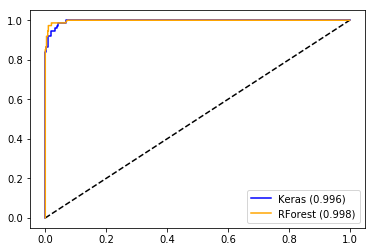

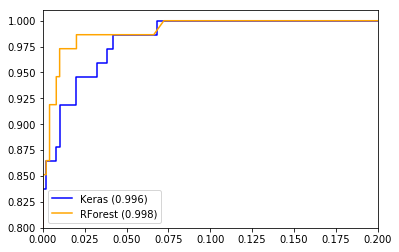

In [106]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from keras.wrappers.scikit_learn import KerasClassifier

predicted_keras = preds
proba_rf = pipeline.predict_proba(X_test)
fpr1, tpr1, thresh1 = roc_curve(y_test, predicted_keras[:, 1])
fpr2, tpr2, thresh2 = roc_curve(y_test, proba_rf[:, 1])

auc1 = roc_auc_score(y_test, predicted_keras[:, 1])
auc2 = roc_auc_score(y_test, proba_rf[:, 1])

plt.figure(1)
plt.plot([0,1], [0,1], "k--", color = 'black')
plt.plot(fpr1, tpr1, label = "Keras ({:.3f})".format(auc1), color = "blue")
plt.plot(fpr2, tpr2, label = "RForest ({:.3f})".format(auc2), color = "orange")
plt.legend(loc = "best")

plt.figure(2)
plt.plot([0,1], [0,1], "k--", color = 'black')
plt.plot(fpr1, tpr1, label = "Keras ({:.3f})".format(auc1), color = "blue")
plt.plot(fpr2, tpr2, label = "RForest ({:.3f})".format(auc2), color = "orange")
plt.legend(loc = "best")
plt.xlim([0, 0.2])
plt.ylim([0.8, 1.01])


In [108]:
from sklearn.metrics import recall_precision_curve

y_score = pipeline.decision_fuction_(X_test)
precision, recall, _ = recall_precision_curve(y_test, y_score)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')

ImportError: cannot import name 'recall_precision_curve' from 'sklearn.metrics' (C:\Users\iko\Anaconda3\lib\site-packages\sklearn\metrics\__init__.py)